# Neural Style Transfer

### Import문
없는 모듈은 `poetry add <모듈명>`으로 추가해주세요.   
python은 django 심화 강의에서와 마찬가지로 3.9.9로 진행해주세요

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image

### GPU가 있는지 확인하기
CUDA Driver가 정상적으로 설치됐다면 아래 명령어에서 리스트에 무언가 담겨있을 겁니다.

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def image2tensor(image):
    
    if isinstance(image, str):
        image = PIL.Image.open(image)
    else:
        pass
    
    np_image = tf.keras.utils.img_to_array(image)
    tf_image = tf.convert_to_tensor(np_image, dtype=tf.float32)
    
    shape = tf.cast(tf_image.shape[:-1], tf.float32)
    max_dim = 512
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    resized_image = tf.image.resize(tf_image, new_shape) / 255.
    expanded_image = resized_image[tf.newaxis, :]
    return expanded_image

In [4]:
def tensor2image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [6]:
content_path = "tfapp/static/content_images/content1.jpeg"
style_path = "tfapp/static/style_images/style1.jpeg"

In [7]:
content_tensor = image2tensor(content_path)
style_tensor = image2tensor(style_path)

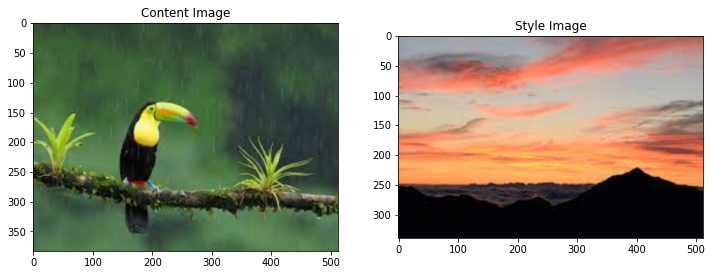

In [8]:
plt.subplot(1, 2, 1)
imshow(content_tensor, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_tensor, 'Style Image')

CPU times: total: 4.45 s
Wall time: 5.2 s


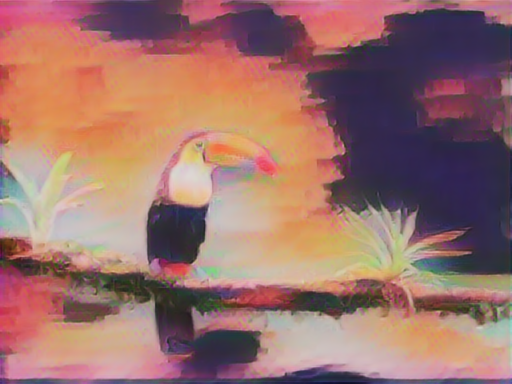

In [9]:
%%time
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(content_tensor, style_tensor)[0]
tensor2image(stylized_image)

## Neural Style Transfer 직접 다뤄보기
아까 수업 때 이야기한 걸 복기하면서 하나씩 구현해보기.

### 1. 훈련된 VGG19를 불러온다.
수업에서 언급했듯, 우선 불러온 모델의 정확도가 어떤지 확인해보자.

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_tensor * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('toucan', 0.9957919),
 ('hornbill', 0.0041406993),
 ('goldfinch', 1.2963362e-05),
 ('bald_eagle', 7.3730985e-06),
 ('black_stork', 7.314325e-06)]

1순위에 **toucan**이 나오는 거보니 모델의 분류 성능은 좋아 보인다.

## 2. 어느 레이어에서 Feature Map을 뽑을지
먼저 VGG19에 어떤 레이어가 있는지 살펴보자.

In [12]:
print()
for layer in vgg.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


논문에서 언급한대로
+ `Content`는 마지막에서 나온 Layer만 선택
+ `Style`의 경우는 중간에 있는 레이어들을 사용하되, 가중치를 두어 다르게 사용한다.

In [13]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
    """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
    # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_tensor * 255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  크기: ", output.numpy().shape)
    print("  최솟값: ", output.numpy().min())
    print("  최댓값: ", output.numpy().max())
    print("  평균: ", output.numpy().mean())
    print()

block1_conv1
  크기:  (1, 340, 512, 64)
  최솟값:  0.0
  최댓값:  674.4691
  평균:  26.815378

block2_conv1
  크기:  (1, 170, 256, 128)
  최솟값:  0.0
  최댓값:  3268.2046
  평균:  117.1877

block3_conv1
  크기:  (1, 85, 128, 256)
  최솟값:  0.0
  최댓값:  6743.29
  평균:  99.22362

block4_conv1
  크기:  (1, 42, 64, 512)
  최솟값:  0.0
  최댓값:  10899.22
  평균:  396.25885

block5_conv1
  크기:  (1, 21, 32, 512)
  최솟값:  0.0
  최댓값:  1851.711
  평균:  29.27147



In [16]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [17]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "[0,1] 사이의 실수 값을 입력으로 받습니다"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_tensor))

print('스타일:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    크기: ", output.numpy().shape)
    print("    최솟값: ", output.numpy().min())
    print("    최댓값: ", output.numpy().max())
    print("    평균: ", output.numpy().mean())
    print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    크기: ", output.numpy().shape)
    print("    최솟값: ", output.numpy().min())
    print("    최댓값: ", output.numpy().max())
    print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.00034143252
    최댓값:  15869.163
    평균:  257.55255

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  48158.586
    평균:  6290.8584

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  372326.2
    평균:  6016.637

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  3677616.8
    평균:  96586.37

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  61807.066
    평균:  852.9537

콘텐츠:
   block5_conv2
    크기:  (1, 23, 32, 512)
    최솟값:  0.0
    최댓값:  1240.923
    평균:  9.846782


In [19]:
style_targets = extractor(style_tensor)['style']
content_targets = extractor(content_tensor)['content']

image = tf.Variable(content_tensor)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [20]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image) # grad = d(loss)/d(image)
    opt.apply_gradients([(grad, image)]) # 
    image.assign(clip_0_1(image))

(1, 383, 512, 3)
(1, 383, 512, 3)


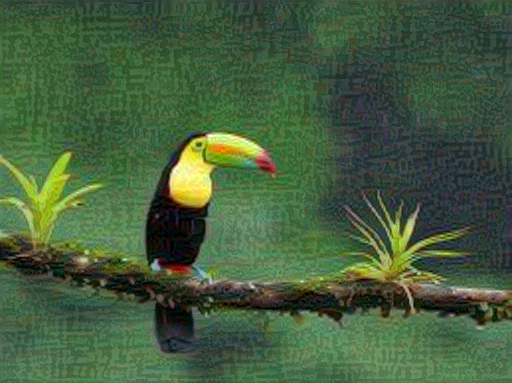

In [21]:
train_step(image)
train_step(image)
train_step(image)
tensor2image(image)

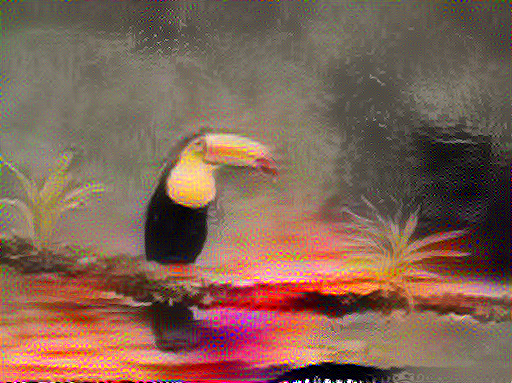

훈련 스텝: 1000
전체 소요 시간: 71.6


In [22]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor2image(image))
    print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))